## Introduction
This notebook aims to evaluate the performance of a cGAN in comparison to our primary solution, the AutoEncoder. The code used to generate the cGAN is inspired by the pix2pix implementation, with modifications in both the generator and discriminator sections. The fit has also been rewritten to include more information and align with our specific objectives.


## Importing libraries




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install visualkeras --quiet
import visualkeras

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import pandas as pd
np.random.seed(seed)

import logging

import random
random.seed(seed)

#Moving to the right directory
os.chdir('/content/drive/MyDrive/ComputerVision/RevivaColor')
print(f'You are currently working in the following path: {os.getcwd()} ')

You are currently working in the following path: /content/drive/.shortcut-targets-by-id/1roZsmEh6bM4KxfIu6c5nYqx4c40dqd6h/RevivaColor 


In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.color import rgb2lab, lab2rgb
from PIL import Image

In [ ]:
import Utils as ut #python file with some functions we used for the projects

## Data

In [ ]:
DATA_PATH = os.getcwd()
INPUT_SHAPE = (256,256,1)
OUTPUT_SHAPE = (256,256,2)
IMAGE_SIZES = (256,256)

In [ ]:
data=ut.load_images(DATA_PATH, resize=True, size=(256,256), lab=True)

In [ ]:
data.shape

(4847, 256, 256, 3)

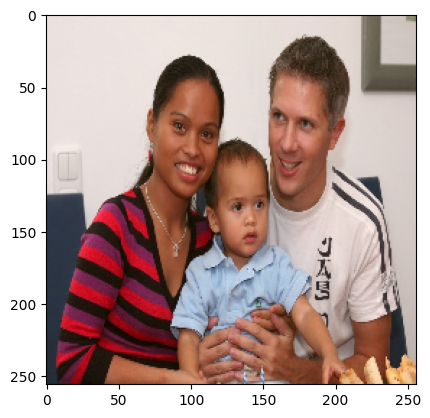

In [ ]:
plt.imshow(lab2rgb(data[0]))

In [ ]:
X = data[:,:,:,0]/100
y = data[:,:,:,1:]/128

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(X_test))

In [ ]:
X_train, X_val, X_test = X_train.reshape(X_train.shape+(1,)), X_val.reshape(X_val.shape+(1,)), X_test.reshape(X_test.shape+(1,))
print(f'The shape of X_train is: {X_train.shape}')
print(f'The shape of X_val is: {X_val.shape}')
print(f'The shape of X_test is: {X_val.shape}')

The shape of X_train is: (3877, 256, 256, 1)
The shape of X_val is: (485, 256, 256, 1)
The shape of X_test is: (485, 256, 256, 1)


In [ ]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE) #shuffle removed

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
INPUT_GEN = (256,256,1)
OUTPUT = (256,256,2)
OUTPUT_CHANNEL = 2
LAMBDA = 100 #parameter for L1
loss_function = tfk.losses.BinaryCrossentropy(from_logits = True)

## Architecture functions

In [ ]:
def unet_down(previous_layer, filters, k_size=4, batchnorm = True, stride = 2, name=''):
    """
    Defines a downsampling block for the U-Net generator.

    Args:
    - previous_layer (tf.Tensor): Input tensor from the previous layer.
    - filters (int): Number of filters in the convolutional layer.
    - k_size (int): Size of the convolutional kernel. Default is 4.
    - batchnorm (bool): Whether to use batch normalization. Default is True.
    - stride (int): Stride for the convolutional layer. Default is 2.
    - name (str): Name suffix for the layers. Default is an empty string.

    Returns:
    - tf.Tensor: Output tensor from the downsampling block.
    """
    weight_setting = tf.random_normal_initializer(0, 0.02)
    x = tfkl.Conv2D(filters,
                    k_size,
                    stride,
                    padding = 'same',
                    use_bias = False,
                    kernel_initializer = weight_setting,
                    name=f'down_{name}')(previous_layer)

    if batchnorm:
        bn = tfkl.BatchNormalization()(x)
        x = tfkl.LeakyReLU(0.2)(bn)
    else:
        x = tfkl.LeakyReLU(0.2)(x)
    return x

In [ ]:
def unet_up(previous_layer, filters, skip = None, k_size=4, dropout = True, do_value = 0.3, stride = 2, name=''):
    """
    Defines an upsampling block for the U-Net generator.

    Args:
    - previous_layer (tf.Tensor): Input tensor from the previous layer.
    - filters (int): Number of filters in the transposed convolutional layer.
    - skip (tf.Tensor or None): Skip connection tensor from the corresponding downsampling block.
    - k_size (int): Size of the transposed convolutional kernel. Default is 4.
    - dropout (bool): Whether to use dropout. Default is True.
    - do_value (float): Dropout rate if dropout is enabled. Default is 0.3.
    - stride (int): Stride for the transposed convolutional layer. Default is 2.
    - name (str): Name suffix for the layers. Default is an empty string.

    Returns:
    - tf.Tensor: Output tensor from the upsampling block.
    """

    weight_setting = tf.random_normal_initializer(0, 0.02)
    if skip is None:
        concat = previous_layer
    else:
        concat = tfkl.Concatenate()([previous_layer, skip])

    x = tfkl.Conv2DTranspose(filters,
                    k_size,
                    stride,
                    padding = 'same',
                    use_bias = False,
                    kernel_initializer = weight_setting,
                    name=f'up_{name}')(concat)

    if dropout:
        do = tfkl.Dropout(do_value)(x)
        x = tfkl.ReLU()(do)
    else:
        x = tfkl.ReLU()(x)
    return x

## Generator part

In [ ]:
def Generator(input_shape = INPUT_GEN):
    """
    Constructs a U-Net based generator model for image generation.

    Args:
    - input_shape (tuple): Input shape of the generator. Default is INPUT_GEN.

    Returns:
    - tf.keras.Model: U-Net generator model with the specified architecture.
    """

    weight_setting = tf.random_normal_initializer(0, 0.02)

    input_layer = tfkl.Input(INPUT_GEN, name = 'input')

    down1 = unet_down(input_layer, filters=64, k_size=4, batchnorm=False, stride=2, name = 'd1' ) # (128,128)
    down2 = unet_down(down1, filters=64, k_size=4, stride=2, name = 'd2' ) # (64,64)
    down3 = unet_down(down2, filters=128, k_size=4, stride=2, name = 'd3' ) # (32,32)
    down4 = unet_down(down3, filters=256, k_size=4, stride=2, name = 'd4' ) # (16,16)
    down5 = unet_down(down4, filters=512, k_size=4, stride=2, name = 'd5' ) # (8,8)
    down6 = unet_down(down5, filters=512, k_size=4, stride=2, name = 'd6' ) # (4,4)

    up1 = unet_up(down6, filters=512 , skip = None, k_size=4, dropout = True, do_value = 0.3, stride = 2, name='u1') # (8,8)
    up2 = unet_up(up1, filters=512 , skip = down5, k_size=4, dropout = True, do_value = 0.3, stride = 2, name='u2') # (16,16)
    up3 = unet_up(up2, filters=256 , skip = down4, k_size=4, dropout = False, stride = 2, name='u3') # (32,32)
    up4 = unet_up(up3, filters=128 , skip = down3, k_size=4, dropout = False, stride = 2, name='u4') # (64,64)
    up5 = unet_up(up4, filters=64 , skip = down2, k_size=4, dropout = False, stride = 2, name='u5') # (128,128)

    concat_last = tfkl.Concatenate()([down1,up5])
    last_layer = tfkl.Conv2DTranspose(OUTPUT_CHANNEL,
                    kernel_size=4,
                    strides=2,
                    padding = 'same',
                    use_bias = False,
                    kernel_initializer = weight_setting,
                    name=f'last')(concat_last)
    return tfk.Model(inputs = input_layer, outputs = last_layer)



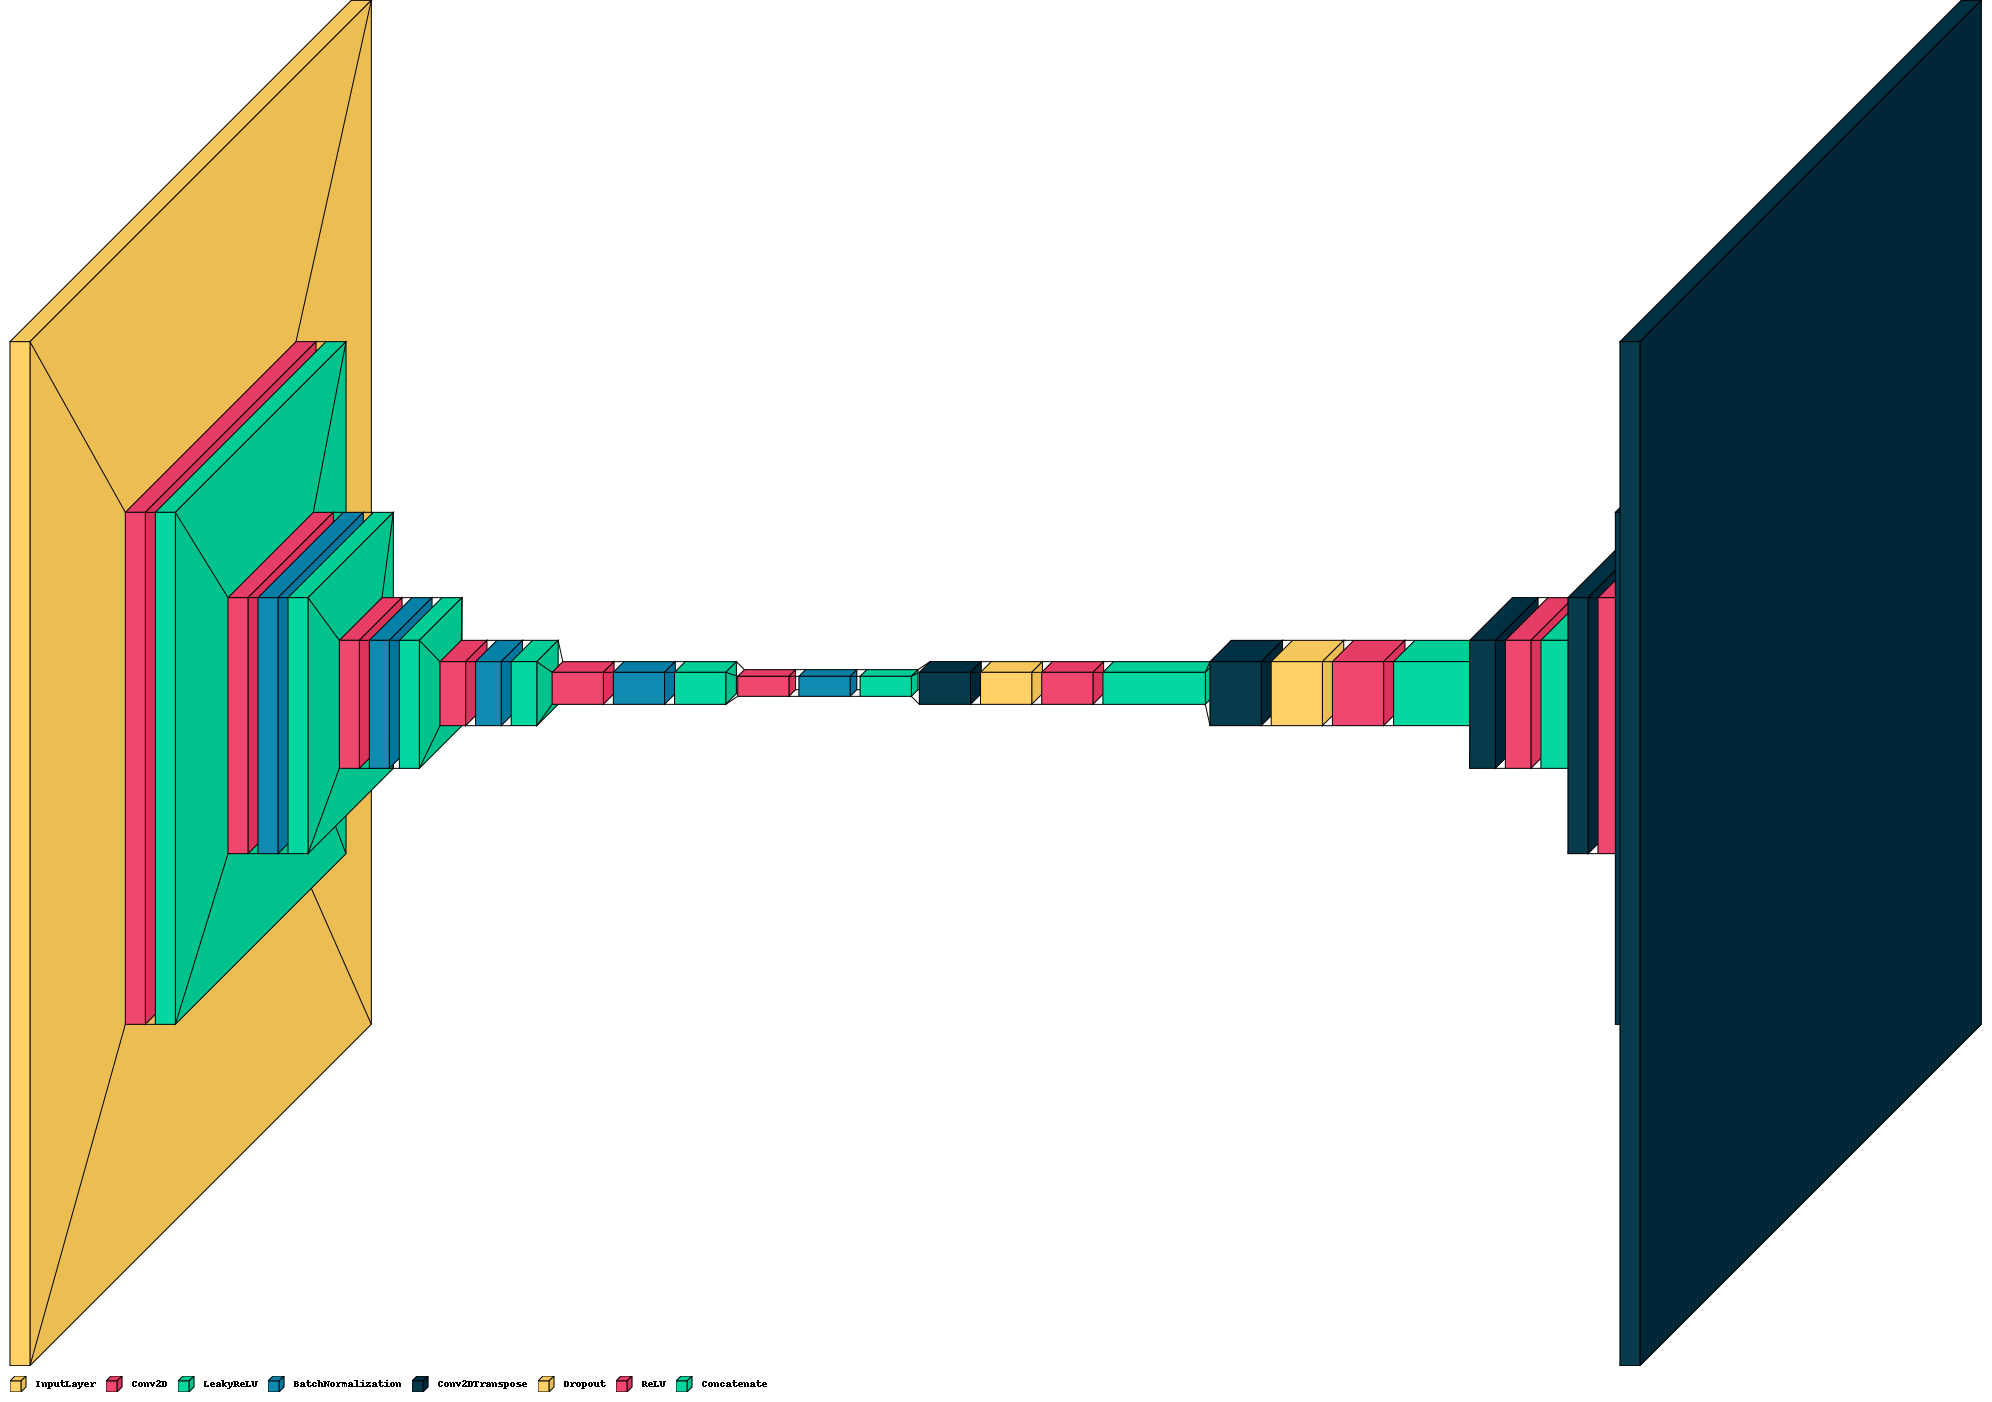

In [ ]:
generator = Generator()
visualkeras.layered_view(generator, legend=True)


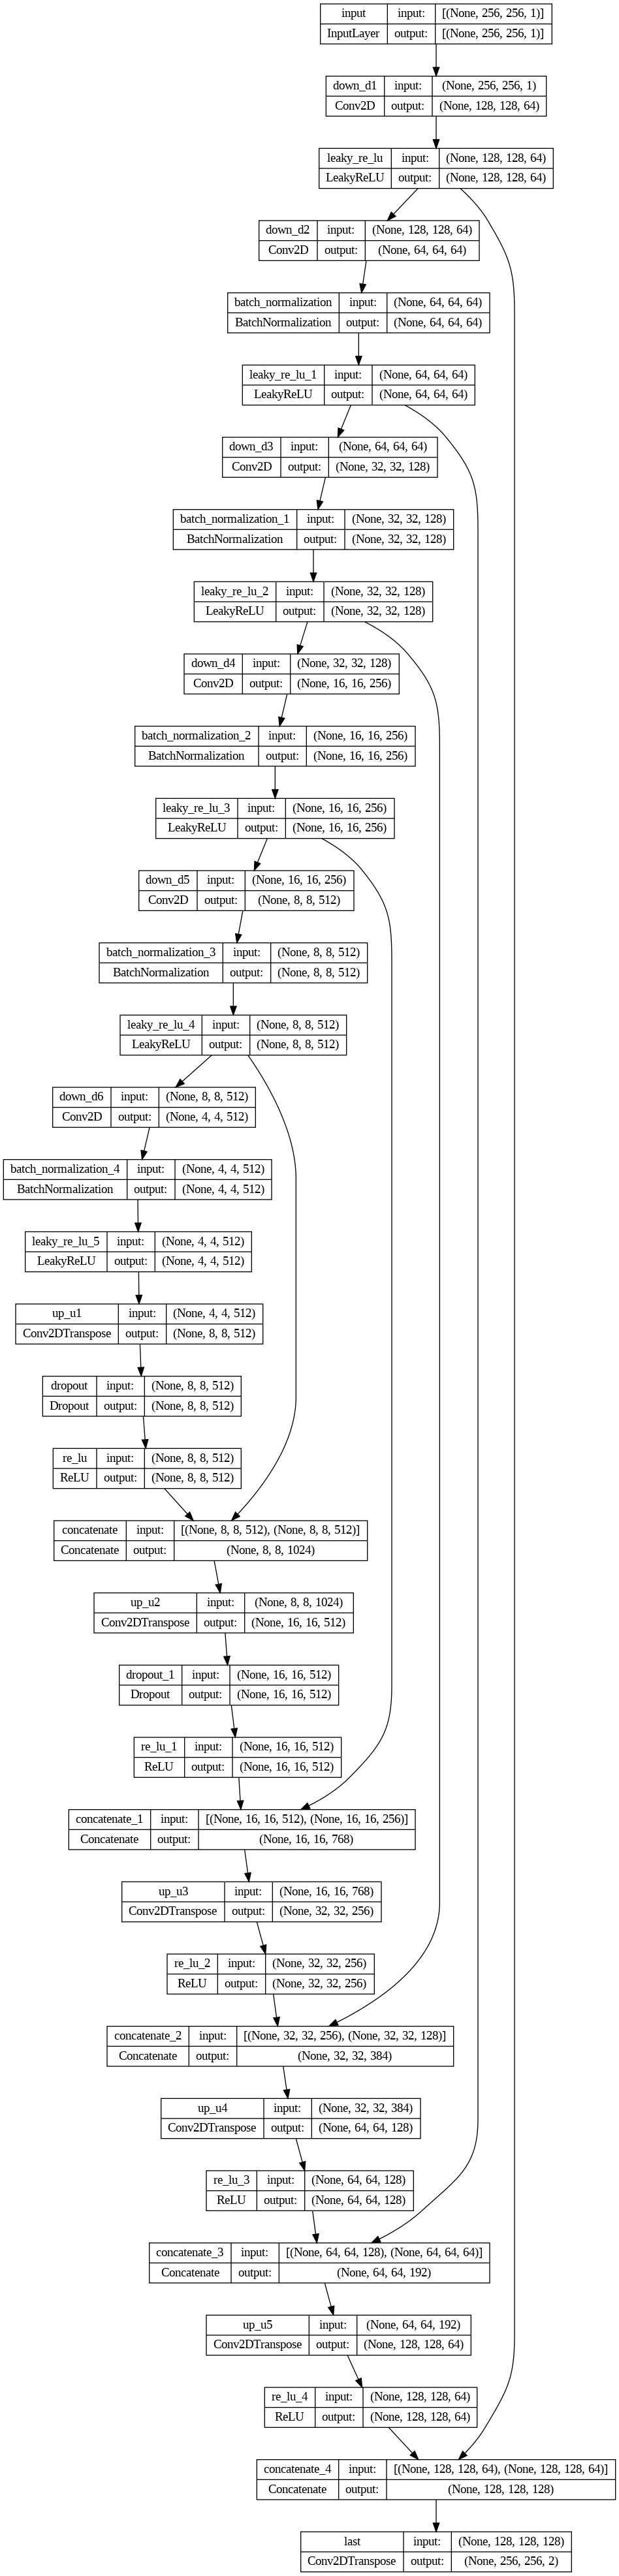

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes = True)

## Discriminator 16x16 Receptive Field

In [ ]:
def Discriminator():
    """
    Constructs a discriminator model with a receptive field of 16x16

    Returns:
    - tf.keras.Model: Discriminator model with the specified architecture.
    """
    weight_setting = tf.random_normal_initializer(0, 0.02)

    input = tfkl.Input(INPUT_GEN)
    target = tfkl.Input(OUTPUT)

    concat = tfkl.Concatenate()([input,target]) #combining and recreating the images in Lab

    down1 = unet_down(concat, filters=64, k_size=4, batchnorm=False, stride=2, name = 'd1disc' ) # (128,128)
    down2 = unet_down(down1, filters=128, k_size=4, batchnorm=True, stride=2, name = 'd2disc' ) # (64,64)
    last = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, kernel_initializer=weight_setting)(down2)  # (61, 61, 1)

    return tfk.Model(inputs=[input,target], outputs=last)

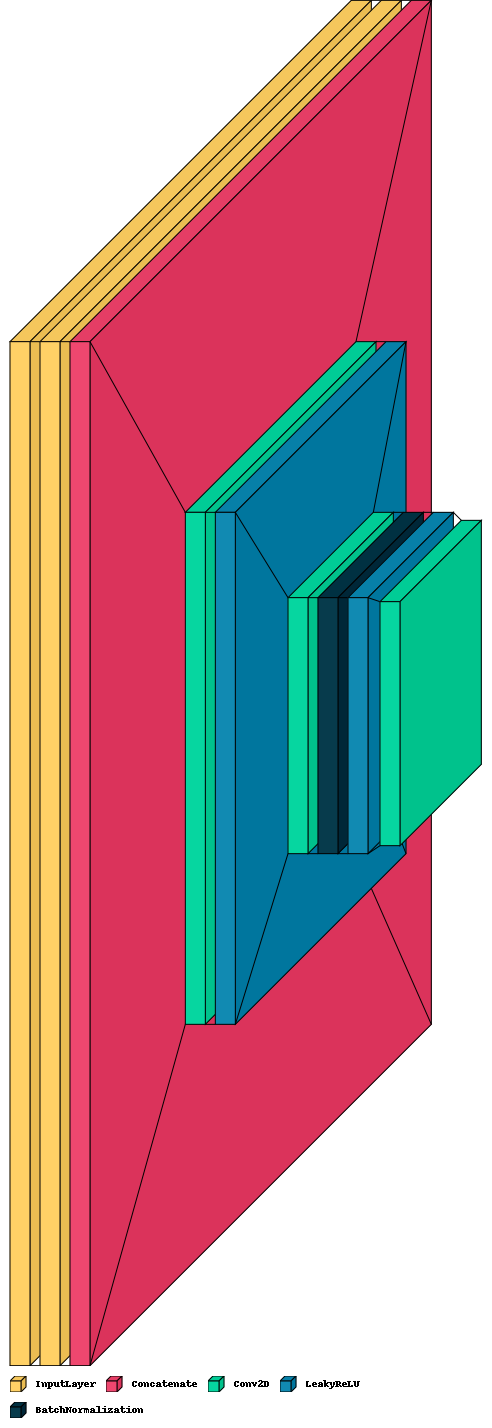

In [ ]:
discriminator = Discriminator()
visualkeras.layered_view(discriminator, legend=True)

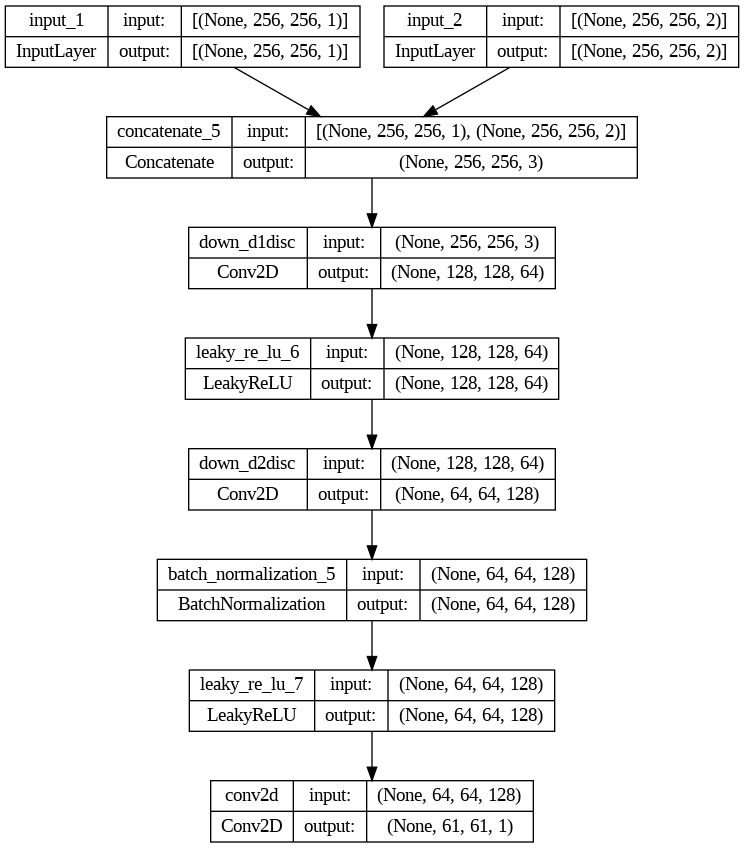

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes = True)

## Losses

In [ ]:
def generator_loss(discriminator_output, generator_output, target, LAMBDA = 100):
    """
    Computes the generator loss given by the combination of L1 and adversarial loss.

    Args:
    - discriminator_output (tf.Tensor): Output tensor from the discriminator.
    - generator_output (tf.Tensor): Output tensor from the generator.
    - target (tf.Tensor): Ground truth target tensor.
    - LAMBDA (float): Weight for the L1 loss term. Default is 100.

    Returns:
    - tuple of tf.Tensor: Total generator loss, GAN loss, and L1 loss.
    """
    gan_loss = loss_function(tf.ones_like(discriminator_output), discriminator_output)

    l1_loss = tf.reduce_mean(tf.abs(target - generator_output)) #MAE

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def discriminator_loss(discriminator_1s, discriminator_0s):
    """
    Computes the discriminator loss which is using generated recomposed images and true images to learn between synthetic and real data.

    Args:
    - discriminator_1s (tf.Tensor): Output tensor from the discriminator for real images.
    - discriminator_0s (tf.Tensor): Output tensor from the discriminator for generated images.

    Returns:
    - tf.Tensor: Total discriminator loss.
    """
    loss_1s = loss_function(tf.ones_like(discriminator_1s), discriminator_1s) #loss on real images (labelled as 1s)

    loss_0s = loss_function(tf.zeros_like(discriminator_0s), discriminator_0s) #loss on generated images (labelled as 0s)

    total_disc_loss = loss_1s + loss_0s

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Train and Fit

In [ ]:
def generate_images(model, test_input, target):
    """
    Generates and displays input, ground truth, and predicted images (used in the fit process).

    Args:
    - model (tf.keras.Model): Generator model.
    - test_input (tf.Tensor): Input image tensor.
    - target (tf.Tensor): Ground truth target tensor.
    """
    prediction = model(test_input, training=True) #using training True to maintain batch statistics and not training ones
    plt.figure(figsize=(15, 15))

    image_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        if i==0:
            L = image_list[0]
            plt.imshow(L*100, cmap='gray')
        # Getting the pixel values in the [0, 1] range to plot.
        else:
            pics = np.zeros((256,256,3))
            pics[:,:,0] = image_list[0][:,:,0]*100
            pics[:,:,1:] = image_list[i][:,:,0:]*128
            plt.imshow(lab2rgb(pics))
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(input_image, target, step):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #gradient tape is used to calculate the gradient of a function
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)  #(y,x) gradient of y with respect to x
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #save losses
    return  gen_gan_loss, gen_l1_loss, gen_total_loss, disc_loss


In [ ]:
def fit(train, test, epochs):
    example_input, example_target = next(iter(test.take(1)))
    start = time.time()
    dataset_lenght = len(train)
    steps = dataset_lenght * epochs
    step_losses = {'gen_gan':[], 'gen_l1': [], 'gen_total':[], 'disc_loss':[]}
    epoch_losses = {'gen_gan':[], 'gen_l1': [], 'gen_total':[], 'disc_loss':[]}
    for step, (input_image, target) in train.repeat().take(steps).enumerate():
        if (step) % dataset_lenght == 0:
            if step != 0:
                print(f'Time taken for 1 epoch: {time.time()-start:.2f} sec')
                #epoch losses
                gt = sum(step_losses['gen_total'])/len(step_losses['gen_total'])
                gg = sum(step_losses['gen_gan'])/len(step_losses['gen_gan'])
                gl1 = sum(step_losses['gen_l1'])/len(step_losses['gen_l1'])
                dl = sum(step_losses['disc_loss'])/len(step_losses['disc_loss'])

                # Save the values into the epoch_losses dictionary
                epoch_losses['gen_total'].append(gt)
                epoch_losses['gen_gan'].append(gg)
                epoch_losses['gen_l1'].append(gl1)
                epoch_losses['disc_loss'].append(dl)

                #print epochs average stats
                print(f'''Epoch: {step//dataset_lenght}, gen_total_loss: {gt}, gen_loss: {gg}, genl1_loss: {gl1}, disc_loss:{dl}''')

                #reset the dict
                step_losses = {'gen_gan':[], 'gen_l1': [], 'gen_total':[], 'disc_loss':[]}
            start = time.time()
            generate_images(generator, example_input, example_target)



        gen_gan_loss, gen_l1_loss, gen_total_loss, disc_loss = train_step(input_image, target, step)
        step_losses['gen_gan'].append(gen_gan_loss)
        step_losses['gen_l1'].append(gen_l1_loss)
        step_losses['gen_total'].append(gen_total_loss)
        step_losses['disc_loss'].append(disc_loss)

        # Training step
        if (step+1) % 100 == 0:
            print('.', end='', flush=True)

        #Save (checkpoint) the model every 5 epochs
        if (step + 1) % (dataset_lenght * 10) == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    return epoch_losses

In [ ]:
checkpoint_dir = './checkpoints_test'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
history = fit(train_dataset, val_dataset, 150)

Previous training failed at 110 epochs, let's restore the checkpoint and restart the model

In [ ]:
# Specify the path to the specific checkpoint file you want to restore
checkpoint_file = './checkpoints_test/ckpt-11'

# Restore the specific checkpoint
checkpoint.restore(checkpoint_file)

# Check if the restoration was successful
print("Checkpoint restored from:", checkpoint_file)

Checkpoint restored from: ./checkpoints_test/ckpt-11


In [ ]:
history = fit(train_dataset, val_dataset, 40)

In [ ]:
generator.save('gen_gan.h5')

In [ ]:
discriminator.save('disc_gan.h5')

**Plots of models losses are not available due to an error given by colab which interrupted the training and corrupted the previous cell output.**

## Testing model with statistics

In [ ]:
#importing trained model
generator = tfk.models.load_model('gen_gan.h5')

In [ ]:
lab_test_pred = generator(X_test, training=True).numpy()
#images from the test set
test_rgb = np.zeros((X_test.shape[0], 256, 256, 3))
test_rgb[:,:,:,0] = X_test[:,:,:,0]*100
test_rgb[:,:,:,1:] = y_test[:,:,:,0:]*128
test_rgb = [lab2rgb(img) for img in test_rgb]

#images generated
generated_pics = np.zeros((X_test.shape[0], 256, 256, 3))
generated_pics[:,:,:,0] = X_test[:,:,:,0]*100
generated_pics[:,:,:,1:] = lab_test_pred [:,:,:,0:]*128
generated_pics = [lab2rgb(img) for img in generated_pics]

In [ ]:
tensor1 = tf.constant(y_test, dtype=tf.float32)
tensor2 = tf.constant(lab_test_pred, dtype=tf.float32)
abs_diff = tf.abs(tensor1-tensor2)
mae_test = tf.reduce_mean(abs_diff)
SSIM_test = tf.reduce_mean(tf.image.ssim(y_test, lab_test_pred, max_val = 2.0))
PSNR_test = tf.reduce_mean(tf.image.psnr(y_test, lab_test_pred, max_val = 2.0))
print(f'The MAE reached on the test set with this cGAN is: {mae_test}')
print(f'The SSIM reached on the test set with this cGAN is: {SSIM_test}')
print(f'The PSNR reached on the test set with this cGAN is: {PSNR_test}')


The MAE reached on the test set with this cGAN is: 0.06884388625621796
The SSIM reached on the test set with this cGAN is: 0.4108526408672333
The PSNR reached on the test set with this cGAN is: 26.476909637451172


### Train set

In [ ]:
#images from the test set
train_pics = np.zeros((10, 256, 256, 3))
train_pics[:,:,:,0] = X_train[0:10,:,:,0]*100
train_pics[:,:,:,1:] = y_train[0:10,:,:,0:]*128
train_pics = [lab2rgb(img) for img in train_pics]

#images generated
t_gen_lab = generator(X_train[0:10,:,:,:], training=True)
train_gen_pics = np.zeros((10, 256, 256, 3))
train_gen_pics[:,:,:,0] = X_train[:10,:,:,0]*100
train_gen_pics[:,:,:,1:] = t_gen_lab [:,:,:,0:]*128
train_gen_pics = [lab2rgb(img) for img in train_gen_pics]

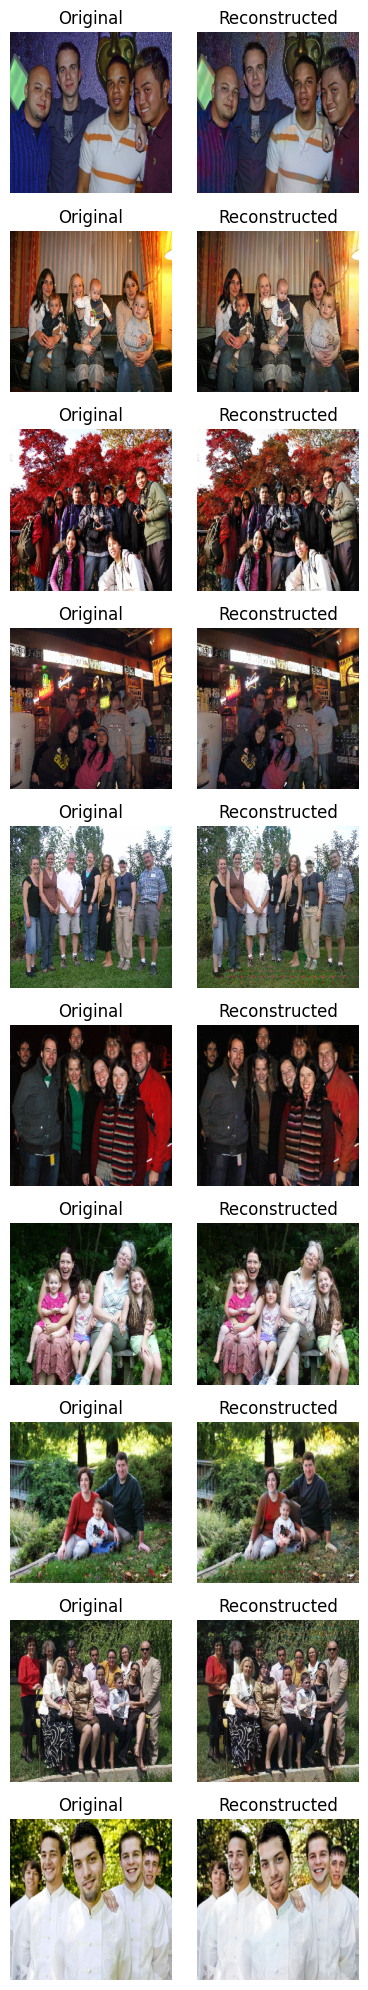

In [ ]:
train_to_plot = []
for i in range(10):
    train_to_plot.append(train_pics[i])
    train_to_plot.append(train_gen_pics[i])

fig, axes = plt.subplots(10, 2, figsize=(4,20))
for i in range(20):
    ax = axes[i%20//2, i%2]
    ax.imshow(np.clip(train_to_plot[i],0,255))
    if i%2==0: ax.set_title('Original')
    else: ax.set_title('Reconstructed')
    ax.axis('off')
plt.tight_layout()
plt.show()

The model seems to perform really well on the training set and could be due to the fact that it is overfitting a bit. However we couldn't run statistics as in the test set due to the hardware constraint.

### Test set

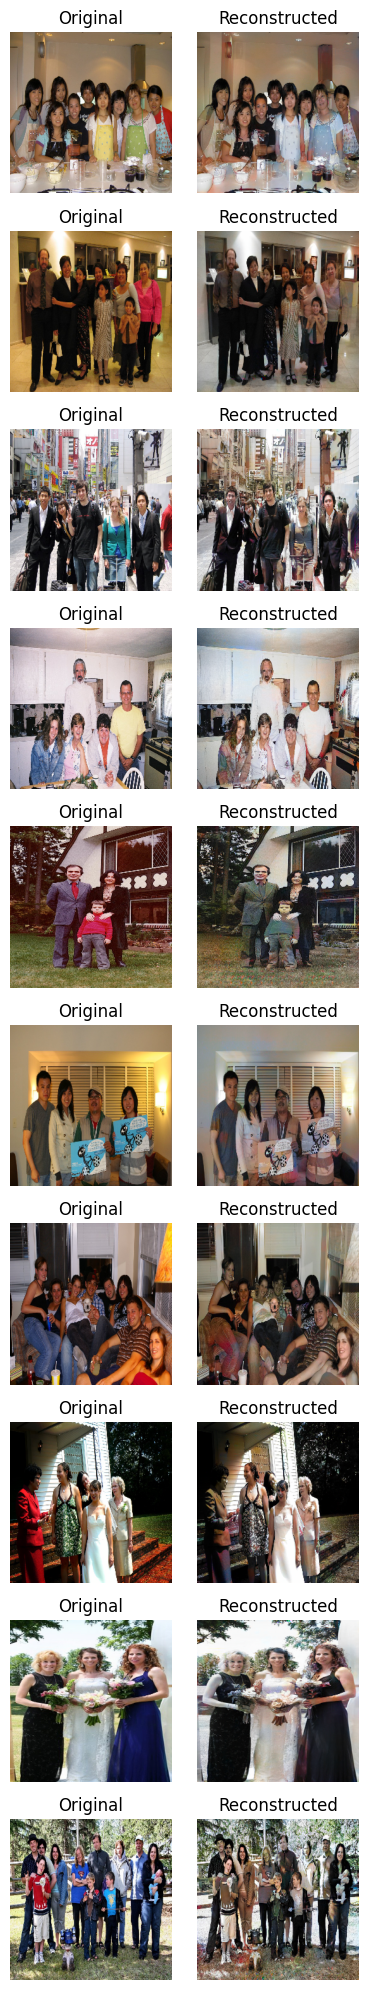

In [ ]:
to_plot = []
for i in range(10):
    to_plot.append(test_rgb[i])
    to_plot.append(generated_pics[i])

fig, axes = plt.subplots(10, 2, figsize=(4,20))
for i in range(20):
    ax = axes[i%20//2, i%2]
    ax.imshow(np.clip(to_plot[i],0,255))
    if i%2==0: ax.set_title('Original')
    else: ax.set_title('Reconstructed')
    ax.axis('off')
plt.tight_layout()
plt.show()

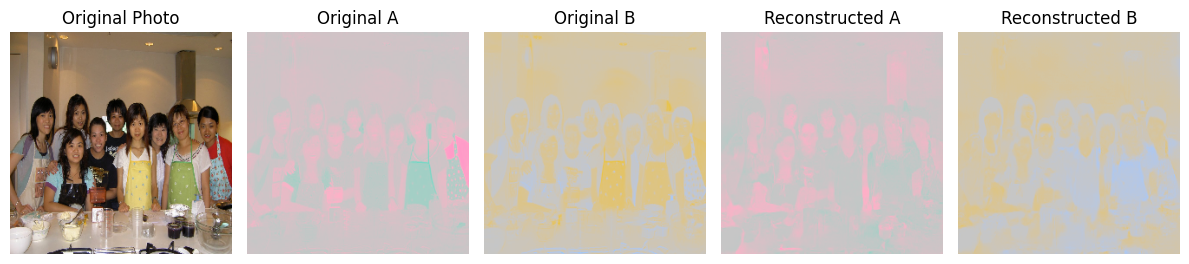

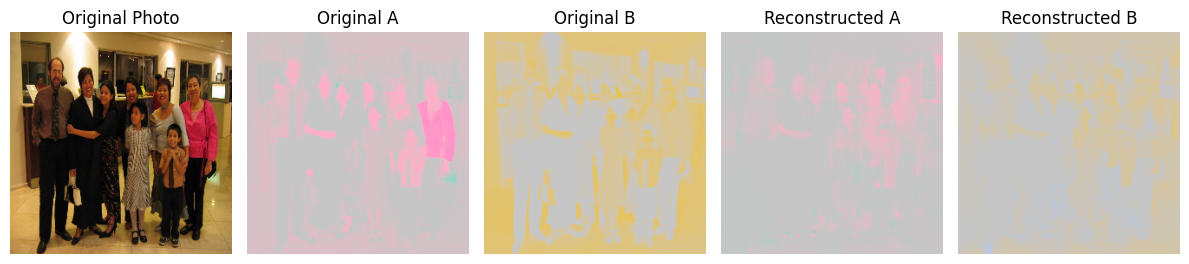

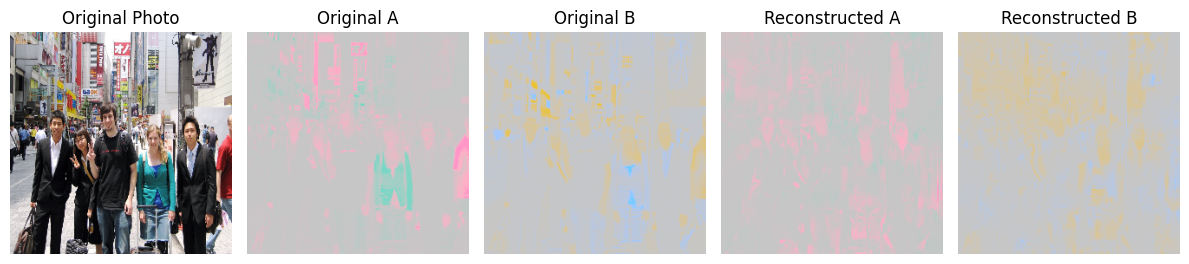

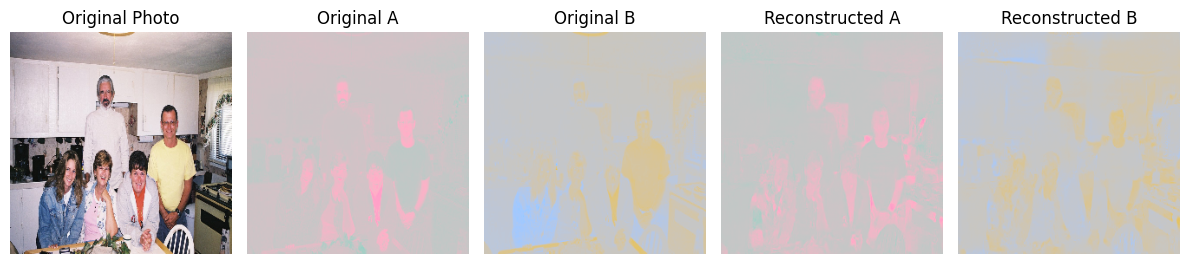

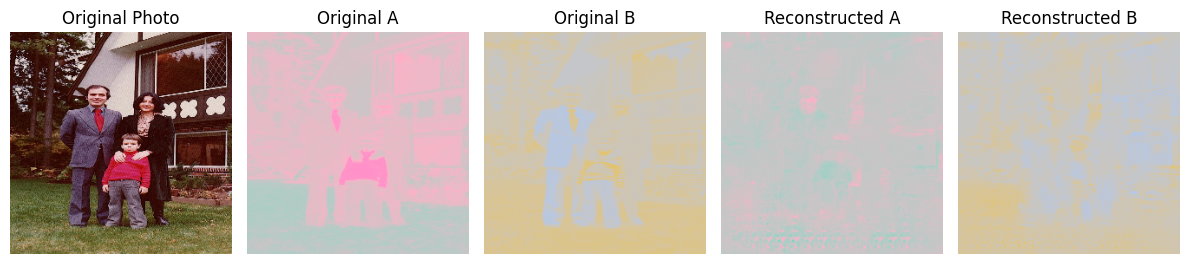

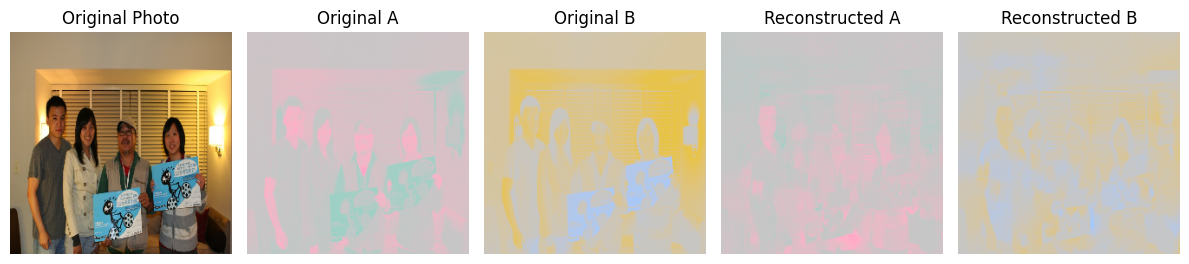

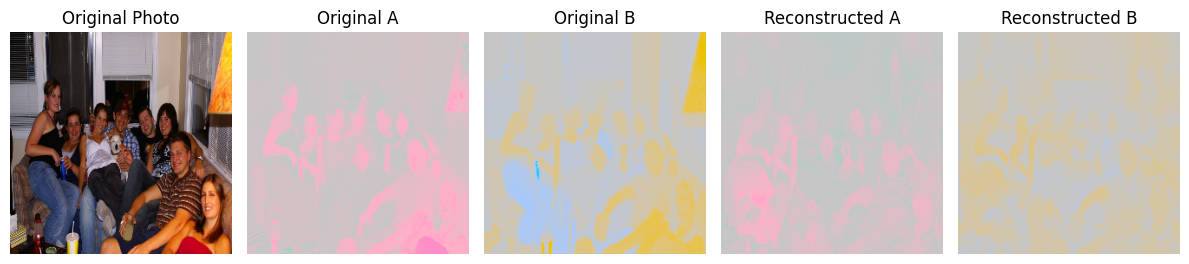

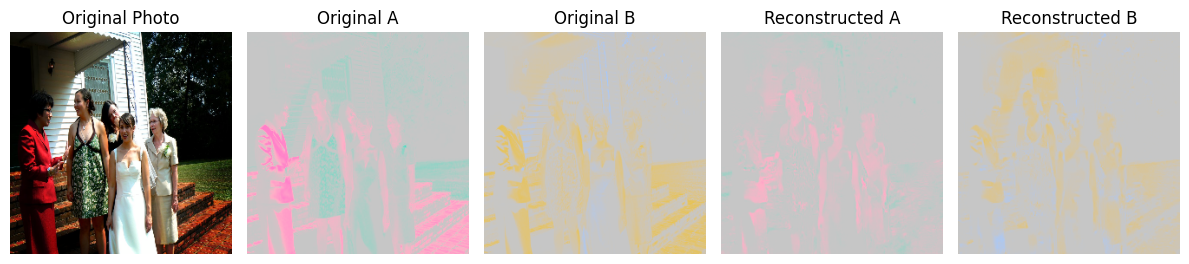

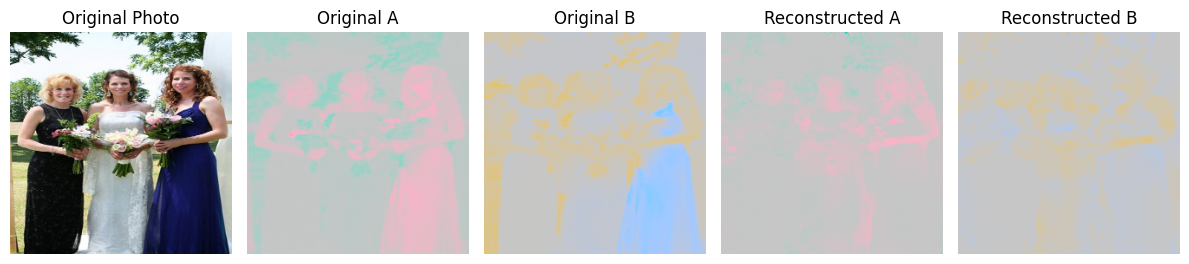

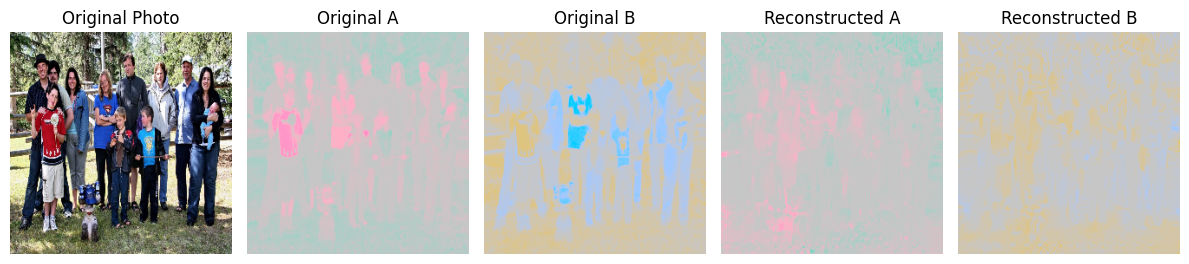

In [ ]:
for i in range(0, len(to_plot), 2):
    ut.plot_lab_spectrums(to_plot[i], to_plot[i+1])

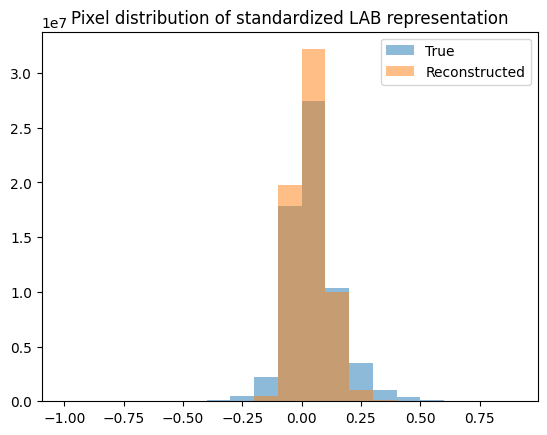

In [ ]:
bins = np.arange(start=-1, stop=1, step=.1)
plt.hist(y_test.flatten(), bins=bins, alpha=0.5, label='True')
plt.hist(lab_test_pred.flatten(), bins=bins, alpha=0.5, label='Reconstructed')
plt.legend()
plt.title('Pixel distribution of standardized LAB representation')
plt.show()

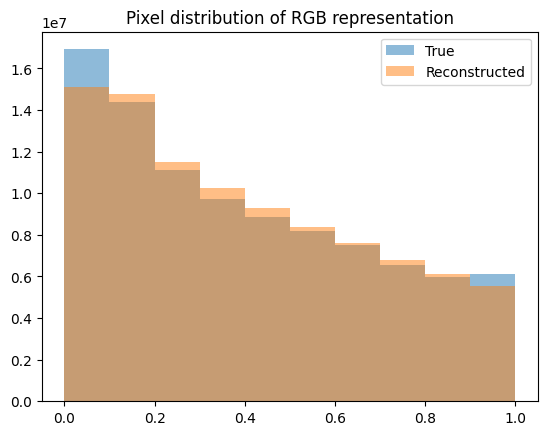

In [ ]:
plt.hist(np.array(test_rgb).flatten(), alpha=0.5, label='True')
plt.hist(np.array(generated_pics).flatten(), alpha=0.5, label='Reconstructed')
plt.legend()
plt.title('Pixel distribution of RGB representation')
plt.show()

On the test set, the model struggles, particularly when it comes to capturing extreme blue values. Simultaneously, it fails to be precise in challenging contexts with numerous people close to each other, leading to more blurry predictions.

### Test the models on a true historical image

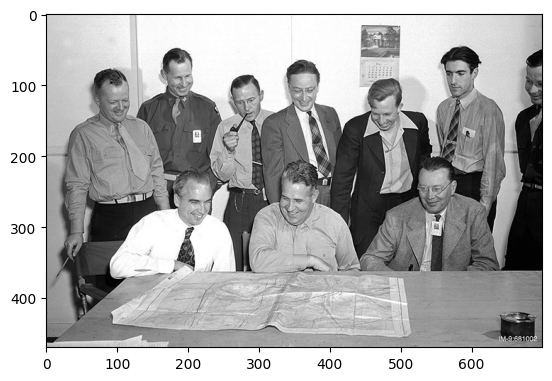

In [ ]:
pic = np.array(Image.open('bradbury.jpg'))
plt.imshow(pic)

In [ ]:
pic = cv2.resize(pic, (256, 256))
pic_lab = rgb2lab(pic)

X_pic = pic_lab[:,:,0] / 100

X_pic = X_pic.reshape(X_pic.shape+(1,))
print(X_pic.shape)

(256, 256, 1)


In [ ]:
# Colorize the image using the autoencoder trained using the PSNR
pred_gan = generator.predict(np.array([X_pic]))
print(pred_gan.shape, pred_gan[0].shape)

image = np.zeros((256, 256, 3))
image[:,:,0] = X_pic[:,:,0] * 100
image[:,:,1:] = pred_gan * 128
image = lab2rgb(image)

1/1 [==============================] - 0s 339ms/step
(1, 256, 256, 2) (256, 256, 2)


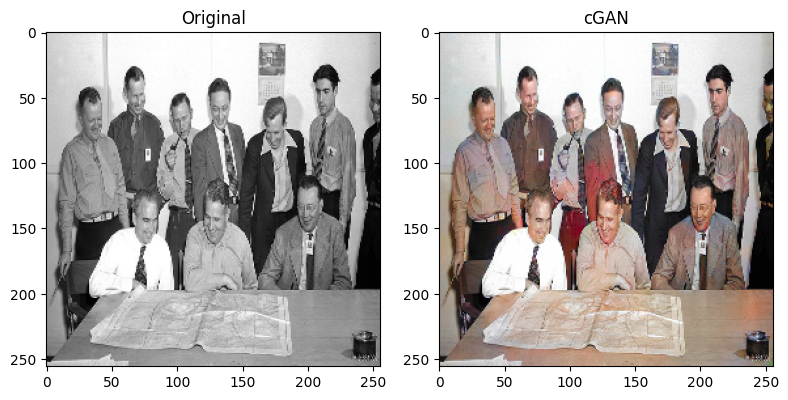

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(pic)
axes[0].set_title('Original')
axes[1].imshow(image)
axes[1].set_title('cGAN')
plt.tight_layout()
plt.show()

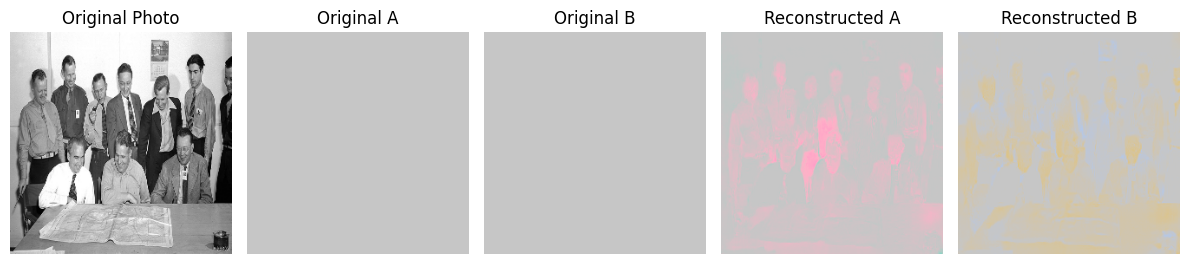

In [ ]:
ut.plot_lab_spectrums(pic, image)

In a real historical image, like the ones plotted above, we can observe that almost all the faces are correctly colored (with the exception of one having a blue hue). However, the model struggles in regions where the clothes of different people are overlapping, resulting in mixed color outputs that are not reasonable.